In this notebook we consider the K2 target

- We correct for K2 motion
- We run the corrected light curve and mesured periods through the pymc3 framework to try and model the transits

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
import lightkurve as lk
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
from lightkurve import search_lightcurvefile
from lightkurve import search_lightcurve
from lightkurve import search_targetpixelfile
import exoplanet as xo

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 18
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True
plt.rcParams['axes.linewidth']=1.5

# Kepler Data

https://exoplanetarchive.ipac.caltech.edu/overview/EPIC%20246711015

In [3]:
star = lk.search_lightcurve('EPIC 246711015',author='EVEREST')
#lk

In [4]:
k2 = star.download_all()

In [5]:
k2

LightCurveCollection of 1 objects:
    0: <KeplerLightCurve LABEL="EPIC 246711015" CAMPAIGN=13 AUTHOR=EVEREST FLUX_ORIGIN=flux>

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

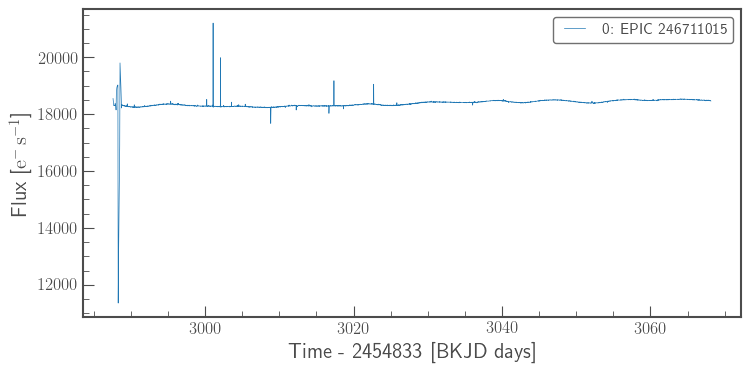

In [6]:
k2.plot()

In [22]:
period1 = 13.284219
period2 = 24.213117

(-2.0, 2.0)

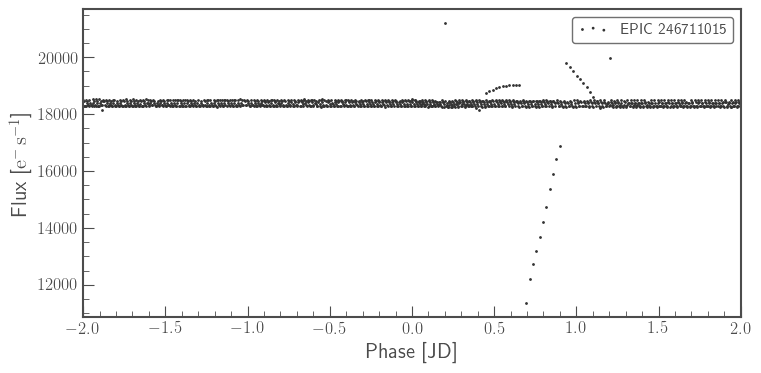

In [42]:
k2[0].fold(period=period1).scatter()
plt.xlim(-2,2)

### We can use the periods measured that are on exofop as a starting point and then throw the corrected light curve into the pymc3 framework to model the transits


https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=k2pandc

In [25]:
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx

In [26]:
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

planet 1 period = 13.284219 +0.002846 -0.001880
planet 2 period = 24.213117 +0.003408 -0.003407

tutorial: https://gallery.exoplanet.codes/tutorials/transit/#the-transit-model-in-pymc3

with stellar variability: https://gallery.exoplanet.codes/tutorials/lc-gp-transit/

In [48]:
periods = [13.284219 , 24.213117]
t0s = periods * np.random.rand(2)

x = k2[0]['time'].value
mu = np.nanmedian(k2[0]['flux'].value)
y = (k2[0]['flux'].value) / mu - 1
yerr = k2[0]['flux_err'].value / mu

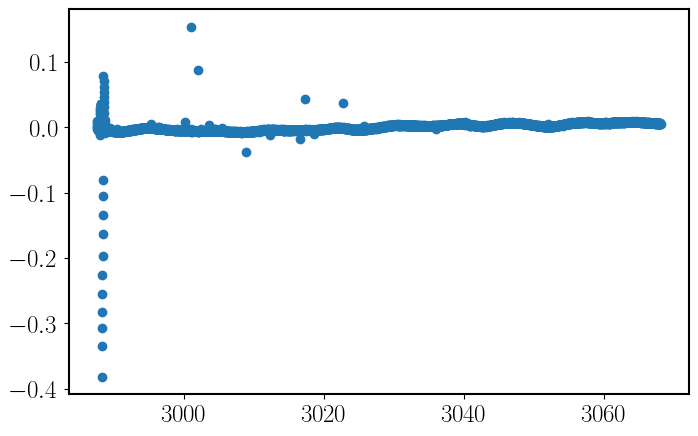

In [49]:
plt.scatter(x,y)


In [43]:
phase_lc = np.linspace(-1, 1, 100)

In [46]:
from astropy import units as units, constants as const

In [56]:
def build_model(mask=None, start=None):

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    with pm.Model() as model:

        # Shared parameters
        mean = pm.Normal("mean", mu=0, sd=1, testval=0)

        # Stellar parameters.  These are usually determined from spectroscopy
        # and/or isochrone fits.
        logg_star = pm.Normal("logg_star", mu=5.24, sd=0.1440)
        r_star = pm.Normal("r_star", mu=0.1240, sd=0.02)

        # Here "factor" is defined s.t. factor * 10**logg / r_star = rho
        factor = 5.141596357654149e-05
        rho_star = pm.Deterministic(
            "rho_star", factor * 10**logg_star / r_star
        )

        # Limb-darkening: adopt Kipping 2013.
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # To get Rp/R*, fit for log(depth).  This requires an impact parameter
        # prior from 0 to 1, because otherwise there's a sqrt(1-b^2) in the
        # conversion that doesn't make sense.  See
        # https://github.com/exoplanet-dev/exoplanet/blob/e99d1bd68654f21efbbf8400a83889a470d2baf7/src/exoplanet/light_curves/limb_dark.py#L73

        b = pm.Uniform("b", lower=0, upper=1)

        log_depth = pm.Normal("log_depth", mu=np.log(1.8e-3), sigma=1)
        depth = pm.Deterministic("depth", tt.exp(log_depth))

        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(depth, b),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        # Orbital parameters for the planets
        #t0 = pm.Normal("t0", mu=t0s, sd=1)
        log_period = pm.Normal("log_period", mu=np.log((periods)), sd=1)
        period = pm.Deterministic("period", pm.math.exp(log_period))


        # Let the eccentricity float, and use the eccentricity distribution
        # from https://arxiv.org/abs/1807.00549 as our prior.
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19(
            "ecc_prior", multi=False, shape=1, fixed=True, observed=ecc
        )
        # Alternative choice:
        # xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Define the orbit model.
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            b=b,
            rho_star=rho_star,
            r_star=r_star,
            ecc=ecc,
            omega=omega,
        )

        transit_model = mean + tt.sum(
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp),
            axis=-1,
        )

        # Convenience function for plotting.
        pm.Deterministic(
            "transit_pred",
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp),
        )

        # Use the GP model from the stellar variability tutorial at
        # https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sd=2)

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1, 5)
        )
        # Rotation period is 2.6 days, from Lomb Scargle  I don't know the rotation period -- need to calculate
        log_prot = pm.Normal("log_prot", mu=np.log(2.606418), sd=0.02)
        prot = pm.Deterministic("prot", tt.exp(log_prot))
        log_Q0 = pm.Normal("log_Q0", mu=0, sd=2)
        log_dQ = pm.Normal("log_dQ", mu=0, sd=2)
        f = pm.Uniform("f", lower=0.01, upper=1)

        # Set up the Gaussian Process model. See
        # https://celerite2.readthedocs.io/en/latest/tutorials/first/ for an
        # introduction. Here, we have a quasiperiodic term:
        kernel = terms.RotationTerm(
            sigma=sigma_rot,
            period=prot,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        #
        # Note mean of the GP is defined here to be zero, so our "observations"
        # will need to subtract the transit model.  The inverse choice could
        # also be made.
        #
        gp = GaussianProcess(
            kernel,
            t=x[mask],
            diag=yerr[mask] ** 2 + tt.exp(2 * log_jitter),
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("transit_obs", observed=y[mask] - transit_model)

        # Compute the GP model prediction for plotting purposes
        pm.Deterministic("gp_pred", gp.predict(y[mask] - transit_model))

        # Track planet radius in Jovian radii
        r_planet = pm.Deterministic(
            "r_planet",
            (ror * r_star) * (1 * units.Rsun / (1 * units.Rjup)).cgs.value,
        )

        # Optimize the MAP solution.
        if start is None:
            start = model.test_point

        map_soln = start

        map_soln = pmx.optimize(
            start=map_soln, vars=[sigma_rot, f, prot, log_Q0, log_dQ]
        )
        map_soln = pmx.optimize(
            start=map_soln,
            vars=[
                log_depth,
                b,
                ecc,
                omega,
                t0,
                period,
                r_star,
                logg_star,
                u_star,
                mean,
            ],
        )
        map_soln = pmx.optimize(start=map_soln)

    return model, map_soln


model, map_estimate = build_model()

TypeError: Wrong number of dimensions: expected 0, got 1 with shape (2,).

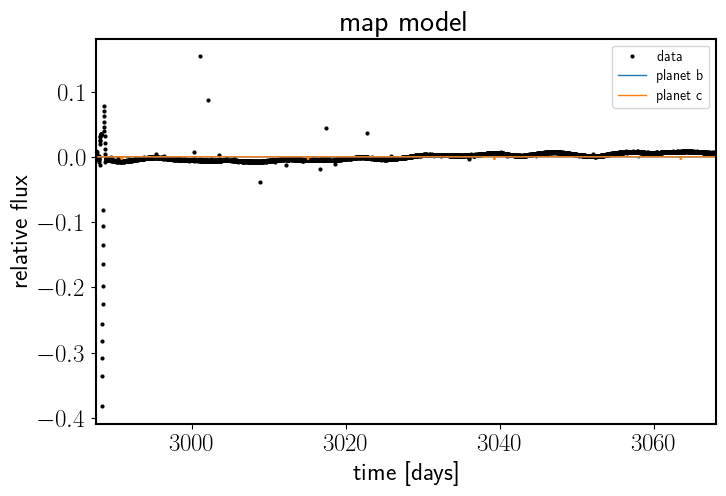

In [45]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

You can now sample from the posterior of this model we just ran

In [70]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, r, u, logP, t0, mean]


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30537 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [71]:
import arviz as az

az.summary(trace, var_names=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period[0],13.271,0.028,13.218,13.312,0.011,0.008,8.0,11.0,1.25
period[1],24.204,0.006,24.194,24.217,0.002,0.001,13.0,71.0,1.13
t0[0],0.439,0.810,-1.146,1.942,0.151,0.135,34.0,23.0,1.06
t0[1],20.184,0.781,18.564,21.347,0.223,0.161,14.0,70.0,1.13
r[0],0.032,0.018,0.011,0.073,0.006,0.005,22.0,43.0,1.23
r[1],0.060,0.004,0.053,0.066,0.000,0.000,58.0,91.0,1.01
b[0],0.583,0.315,0.123,1.078,0.119,0.106,8.0,40.0,1.23
b[1],0.231,0.149,0.024,0.531,0.036,0.026,19.0,58.0,1.09
u[0],0.466,0.314,0.006,1.051,0.045,0.032,49.0,122.0,1.03
u[1],0.066,0.312,-0.491,0.693,0.052,0.037,36.0,123.0,1.04


In [72]:
import corner

truth = dict(
    zip(
        ["period", "r"],
        pmx.eval_in_model([period, r], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=["period", "r"],
    truths=truth,
)

TypeError: cannot perform reduce with flexible type

Phase Plots

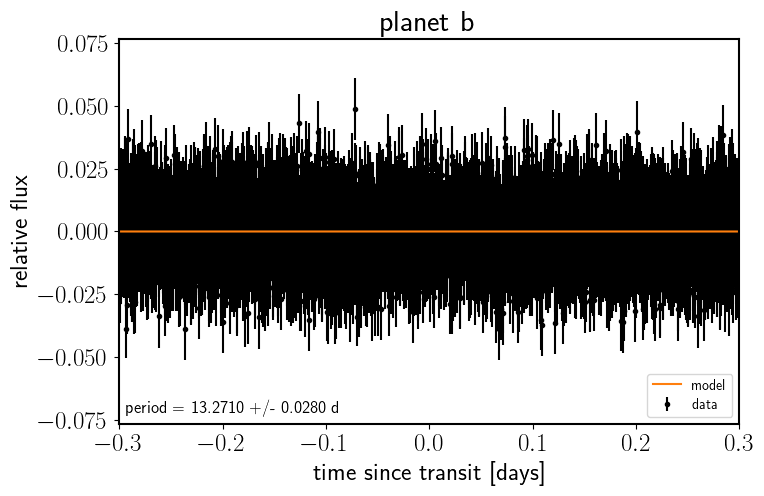

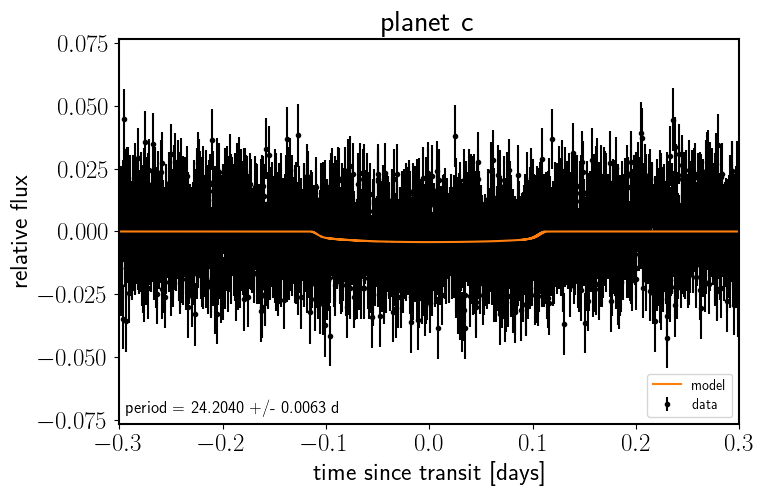

In [73]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    period_trace = trace.posterior["period"].values[:, :, n]
    p = np.median(period_trace)
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    lcs = trace.posterior["light_curves"].values
    other = np.median(lcs[:, :, :, (n + 1) % 2], axis=(0, 1))

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = lcs[:, :, inds, n] + trace.posterior["mean"].values[:, :, None]
    pred = np.median(pred, axis=(0, 1))
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(period_trace), np.std(period_trace)
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)